<a href="https://colab.research.google.com/github/alexandrasouly/fastai_exploration/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 727kB 13.1MB/s 
     |████████████████████████████████| 194kB 33.7MB/s 
     |████████████████████████████████| 1.2MB 32.8MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
Mounted at /content/gdrive


## Regression
We're going to do a key point model. A key point refers to a specific location represented in an image—in this case, we'll use images of people and we'll be looking for the center of the person's face in each image. That means we'll actually be predicting two values for each image: the row and column of the face center.
We will use the Biwi Kinect Head Pose dataset for this section.

In [2]:
path = untar_data(URLs.BIWI_HEAD_POSE)

There are 24 directories numbered from 01 to 24 (they correspond to the different people photographed), and a corresponding .obj file for each (we won't need them here). 
Inside the subdirectories, we have different frames, each of them come with an image (_rgb.jpg) and a pose file (_pose.txt). We can easily get all the image files recursively with get_image_files, then write a function that converts an image filename to its associated pose file:


In [4]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/21/frame_00623_pose.txt')

In [5]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

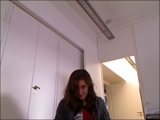

In [6]:
im.to_thumb(160)


The Biwi dataset website used to explain the format of the pose text file associated with each image, which shows the location of the center of the head. The details of this aren't important for our purposes, so we'll just show the function we use to extract the head center point:

In [7]:

cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

  

One important point to note is that we should not just use a random splitter. The reason for this is that the same people appear in multiple images in this dataset, but we want to ensure that our model can generalize to people that it hasn't seen yet. Each folder in the dataset contains the images for one person. Therefore, we can create a splitter function that returns true for just one person, resulting in a validation set containing just that person's images.

The only other difference from the previous data block examples is that the second block is a PointBlock. This is necessary so that fastai knows that the labels represent coordinates; that way, it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images:

In [8]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


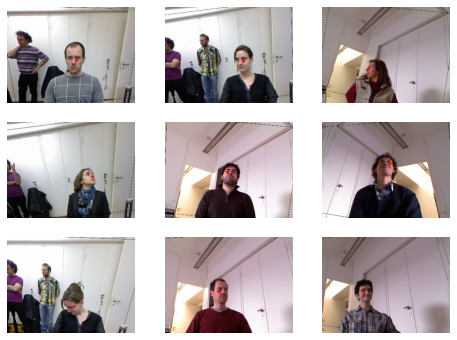

In [9]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [10]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [11]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


We didn't specify a loss function, which means we're getting whatever fastai chooses as the default. Let's see what it picked for us:

In [ ]:

dls.loss_func


This makes sense, since when coordinates are used as the dependent variable, most of the time we're likely to be trying to predict something as close as possible; that's basically what MSELoss (mean squared error loss) does. If you want to use a different loss function, you can pass it to cnn_learner using the loss_func parameter.

Note also that we didn't specify any metrics. That's because the MSE is already a useful metric for this task (although it's probably more interpretable after we take the square root).`

In [12]:
learn.lr_find()

KeyboardInterrupt: ignored

In [ ]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time


In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))